In [19]:
! pip install ace_tools


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


In [23]:
df_main = pd.read_csv("dataframes/incidenti_tfl_2019.csv")
df_ages = pd.read_csv("dataframes/age_range_counts_to_merge.csv")
df_vehicles = pd.read_csv("dataframes/vehicles_by_cat.csv")


In [24]:
print(df_main.keys())
df_main.head()

Index(['$type', 'id', 'lat', 'lon', 'location', 'date', 'severity', 'borough',
       'casualties', 'vehicles'],
      dtype='object')


,$type,id,lat,lon,location,date,severity,borough,casualties,vehicles
0,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345979,51.570865,-0.231959,On Edgware Road Near The Junction With north C...,2019-01-04T21:22:00Z,Slight,Barnet,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
1,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345980,51.603859,-0.187240,On Willow Way Near The Junction With Long Lane,2019-01-04T23:33:00Z,Slight,Barnet,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
2,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345981,51.512198,-0.153122,On north Audley Street Near The Junction With ...,2019-01-04T22:15:00Z,Slight,City of Westminster,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
3,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345982,51.431480,-0.016083,On Bromley Road Near The Junction With Daneswo...,2019-01-04T18:00:00Z,Slight,Lewisham,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
4,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345983,51.473487,0.145202,On Belmont Road Near The Junction With Bedonwe...,2019-01-04T20:45:00Z,Slight,Bexley,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...


```json
exmpl = {
    "$type": "Tfl.Api.Presentation.Entities.AccidentStats.AccidentDetail, Tfl.Api.Presentation.Entities",
    "id": 345979,
    "lat": 51.570865,
    "lon": -0.231959,
    "location": "On Edgware Road Near The Junction With north Circular Road",
    "date": "2019-01-04T21:22:00Z",
    "severity": "Slight",
    "borough": "Barnet",
    "casualties": [{
        "$type": "Tfl.Api.Presentation.Entities.AccidentStats.Casualty, Tfl.Api.Presentation.Entities",
        "age": 20,
        "class": "Driver",
        "severity": "Slight",
        "mode": "PoweredTwoWheeler",
        "ageBand": "Adult"
    }],
    "vehicles": [{
        "$type": "Tfl.Api.Presentation.Entities.AccidentStats.Vehicle, Tfl.Api.Presentation.Entities",
        "type": "Motorcycle_500cc_Plus"
    }, {
        "$type": "Tfl.Api.Presentation.Entities.AccidentStats.Vehicle, Tfl.Api.Presentation.Entities",
        "type": "Car"
    }]
}
```

In [25]:
# Dropped unecessary cols
# General idea keep: [id, lat, lon, date, TOD, severity, boroughs..., casualties_age_range..., num_vehicles_per_type...]
df_main.drop(columns=['$type', 'location', 'casualties', 'vehicles'], inplace=True)

In [26]:
# converting 'severity' to cardinal indicator
df_main['severity'] = df_main['severity'].map({'Slight': 1, 'Serious': 2, 'Fatal': 3})

In [27]:
# Encode boroughs to OHE
borough_encoded = pd.get_dummies(df_main['borough'], prefix='borough', dtype=int)
df_main = pd.concat([df_main, borough_encoded], axis=1)
df_main.drop('borough', axis=1, inplace=True)


Dividing time_of_day using pd.cut(). Here the intervals have a practical meaning, so pd.cut() is better than pd.qcut().

In [28]:
# Time of day Pre Processing 
df_main['date'] = pd.to_datetime(df_main['date'])
# df_main['date'].dt.hour.plot.hist(bins=24, color='skyblue', edgecolor='black', alpha=0.7)
df_main['time_of_day'], bins = pd.cut(df_main['date'].dt.hour, bins=[0, 6, 12, 18, 24] , labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False, retbins=True)
print(bins)
df_main.head()

[ 0  6 12 18 24]


,id,lat,lon,date,severity,borough_Barking and Dagenham,borough_Barnet,borough_Bexley,borough_Brent,borough_Bromley,...,borough_Merton,borough_Newham,borough_Redbridge,borough_Richmond upon Thames,borough_Southwark,borough_Sutton,borough_Tower Hamlets,borough_Waltham Forest,borough_Wandsworth,time_of_day
0,345979,51.570865,-0.231959,2019-01-04 21:22:00+00:00,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Evening
1,345980,51.603859,-0.187240,2019-01-04 23:33:00+00:00,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Evening
2,345981,51.512198,-0.153122,2019-01-04 22:15:00+00:00,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Evening
3,345982,51.431480,-0.016083,2019-01-04 18:00:00+00:00,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Evening
4,345983,51.473487,0.145202,2019-01-04 20:45:00+00:00,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Evening


In [29]:
# Encode time_of_day to OHE
time_of_day_encoded = pd.get_dummies(df_main['time_of_day'], prefix='time_of_day', dtype=int)
df_main = pd.concat([df_main, time_of_day_encoded], axis=1)
df_main.drop('time_of_day', axis=1, inplace=True)
df_main.head()

,id,lat,lon,date,severity,borough_Barking and Dagenham,borough_Barnet,borough_Bexley,borough_Brent,borough_Bromley,...,borough_Richmond upon Thames,borough_Southwark,borough_Sutton,borough_Tower Hamlets,borough_Waltham Forest,borough_Wandsworth,time_of_day_Night,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening
0,345979,51.570865,-0.231959,2019-01-04 21:22:00+00:00,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,345980,51.603859,-0.187240,2019-01-04 23:33:00+00:00,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,345981,51.512198,-0.153122,2019-01-04 22:15:00+00:00,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,345982,51.431480,-0.016083,2019-01-04 18:00:00+00:00,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,345983,51.473487,0.145202,2019-01-04 20:45:00+00:00,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [30]:
# Each Dataframe comes through pre processing in its own file

# CASUALTIES_AG_RANGE
df_merged = df_main.merge(df_ages, on='id', how='left')


# NUM OG VEHICLES PER TYPE
df_merged = df_merged.merge(df_vehicles, on='id', how='left')


print(df_merged.keys())
df_merged.head()

Index(['id', 'lat', 'lon', 'date', 'severity', 'borough_Barking and Dagenham',
       'borough_Barnet', 'borough_Bexley', 'borough_Brent', 'borough_Bromley',
       'borough_Camden', 'borough_City of London',
       'borough_City of Westminster', 'borough_Croydon', 'borough_Ealing',
       'borough_Enfield', 'borough_Greenwich', 'borough_Hackney',
       'borough_Hammersmith and Fulham', 'borough_Haringey', 'borough_Harrow',
       'borough_Havering', 'borough_Hillingdon', 'borough_Hounslow',
       'borough_Islington', 'borough_Kensington and Chelsea',
       'borough_Kingston', 'borough_Lambeth', 'borough_Lewisham',
       'borough_Merton', 'borough_Newham', 'borough_Redbridge',
       'borough_Richmond upon Thames', 'borough_Southwark', 'borough_Sutton',
       'borough_Tower Hamlets', 'borough_Waltham Forest', 'borough_Wandsworth',
       'time_of_day_Night', 'time_of_day_Morning', 'time_of_day_Afternoon',
       'time_of_day_Evening', 'casualty_age_0-23', 'casualty_age_24-30',
   

,id,lat,lon,date,severity,borough_Barking and Dagenham,borough_Barnet,borough_Bexley,borough_Brent,borough_Bromley,...,casualty_age_0-23,casualty_age_24-30,casualty_age_31-38,casualty_age_39-50,casualty_age_50+,Car,Heavy_Vehicles,Motorcycle,Other,Pedalcycle
0,345979,51.570865,-0.231959,2019-01-04 21:22:00+00:00,1,0,1,0,0,0,...,1,0,0,0,0,1,0,1,0,0
1,345980,51.603859,-0.187240,2019-01-04 23:33:00+00:00,1,0,1,0,0,0,...,0,1,0,0,0,2,0,1,0,0
2,345981,51.512198,-0.153122,2019-01-04 22:15:00+00:00,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,345982,51.431480,-0.016083,2019-01-04 18:00:00+00:00,1,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
4,345983,51.473487,0.145202,2019-01-04 20:45:00+00:00,1,0,0,1,0,0,...,1,1,0,0,0,2,0,0,0,0


In [31]:
df_merged.to_csv('dataframes/merged_nov_29.csv', index=False)

Now we need to standardize numerical values (num_casualties_per_age_range, num_vehicles_per_type)

In [32]:
num_cols = ['casualty_age_0-23', 'casualty_age_24-30', 'casualty_age_31-38', 'casualty_age_39-50', 'casualty_age_50+', 'Car', 'Heavy_Vehicles', 'Motorcycle', 'Other', 'Pedalcycle']

In [ ]:
missing_cols = [col for col in num_cols if col not in df_merged.columns]
if missing_cols:
    raise ValueError(f"The following columns are missing from the DataFrame: {missing_cols}")

scaler = StandardScaler()
df_original = df_merged.copy() 
df_merged[num_cols] = scaler.fit_transform(df_merged[num_cols])



In [34]:
def highlight_changes(original_df, transformed_df, columns_to_compare):
    comparison = original_df[columns_to_compare].copy()
    for col in columns_to_compare:
        comparison[f"{col}_transformed"] = transformed_df[col]

    for col in columns_to_compare:
        comparison[f"{col}_changed"] = comparison[col] != comparison[f"{col}_transformed"]

    return comparison

In [37]:
comparison_df = highlight_changes(df_original, df_merged, num_cols)

print("Changes in Standardized Data:")
print(comparison_df)

Changes in Standardized Data:
       casualty_age_0-23  casualty_age_24-30  casualty_age_31-38  \
0                      1                   0                   0   
1                      0                   1                   0   
2                      0                   0                   0   
3                      1                   0                   0   
4                      1                   1                   0   
...                  ...                 ...                 ...   
50621                  0                   0                   1   
50622                  1                   0                   0   
50623                  1                   0                   0   
50624                  1                   0                   0   
50625                  1                   1                   0   

       casualty_age_39-50  casualty_age_50+  Car  Heavy_Vehicles  Motorcycle  \
0                       0                 0    1               0         

### Implementation of the baseline model: Linear Regression

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
features = ['casualty_age_0-23', 'casualty_age_24-30', 'casualty_age_31-38', 
            'casualty_age_39-50', 'casualty_age_50+', 'Car', 'Heavy_Vehicles', 
            'Motorcycle', 'Other', 'Pedalcycle']

X = df_merged[features]
y = df_merged['severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")


def plot_predictions(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, edgecolor='w')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.show()

def plot_residuals(y_test, y_pred):
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, bins=20, color='blue', alpha=0.6)
    plt.axvline(0, color='red', linestyle='--', linewidth=2)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Residuals Distribution')
    plt.show()


Mean Squared Error: 0.14
R-squared Score: 0.03


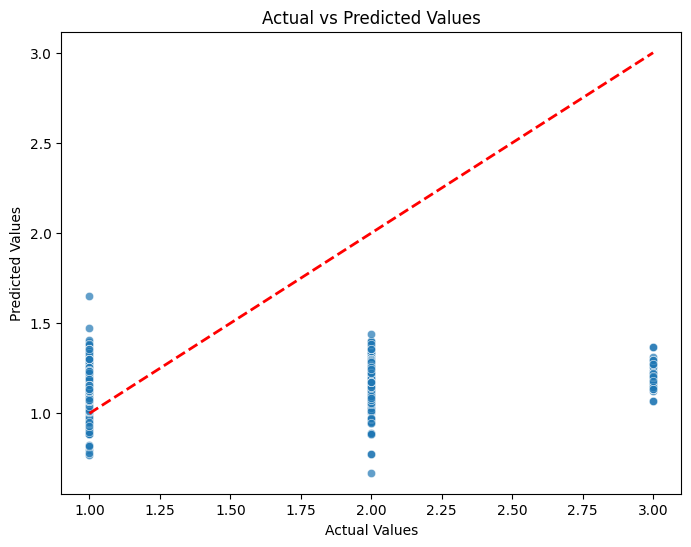

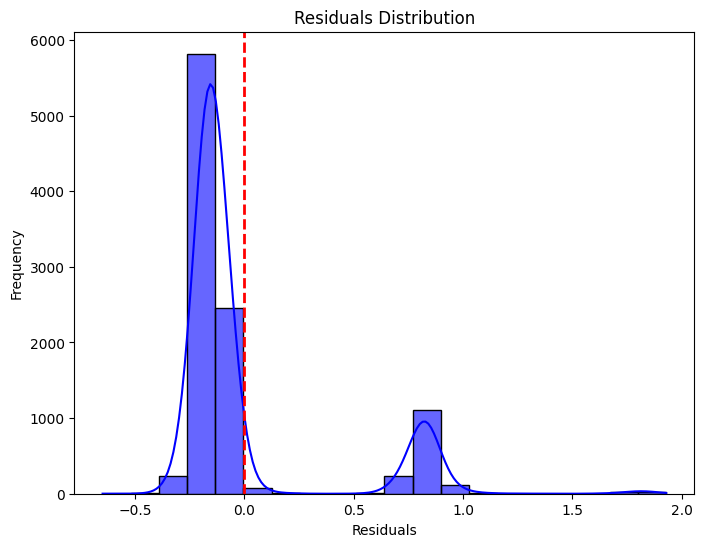

In [41]:
plot_predictions(y_test, y_pred)
plot_residuals(y_test, y_pred)

# NOTES SECTION

## 3 OPTIONS:

* Forecasting
 * Determine out of the dataset what would happen
 * Predict accidents most likely
 * we could use past year data and compare directly with more recent data

* Corelating variables
 * Finding relationship betweetn different variables
 * expanding knowledge base to variables such as
 * Street direction, speed limit, street light, roundabout presence
 * tackle problems that normal statistics patterns or resarch can struggle with
 * Anomaly detection


* Optimization
 * Optimize the dataset
 * Most likely determining the best way to have the London transportation system
 * A simulation, hard to determine results




We could study what subjects are more at risk of severe accidents

What parts of the city are the most at risk

For insurance purposes


IDEA:
We could study the correlation between variables and accidents -> building a cost function to determine the reliability of a certain subject
Could be useful for INSURANCE COMPANIES